# Spencer Hallyburton, Homework 7
## Collaborator: Salvador Barragan

## APMTH 207: Stochastic Methods for Data Analysis, Inference and Optimization

**Due Date: ** Friday, March 23rd, 2018 at 11:00am

In [324]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats

import seaborn as sns; sns.set()
import pandas as pd

import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal
import time
import random

## Problem 1: Gibbs Sampling On A Bivariate Normal

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \cdot\vert $ is the matrix determinant operator.

In the following, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

* Write a Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. 
* Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. 
* You must justify your choice of parameters. 

In [190]:
# Define the gibbs algorithm
def gibbs(xgiveny_sample, ygivenx_sample, N, start = [0,0]):
    x=start[0]
    y=start[1]
    samples=np.zeros((N+1, 2))
    samples[0,0]=x
    samples[0,1]=y
    
    for i in range(1,N,2):
        x=xgiveny_sample(y)
        samples[i,0]=x
        samples[i, 1]=y
        
        y=ygivenx_sample(x)
        samples[i+1,0]=x
        samples[i+1,1]=y
        
    return samples

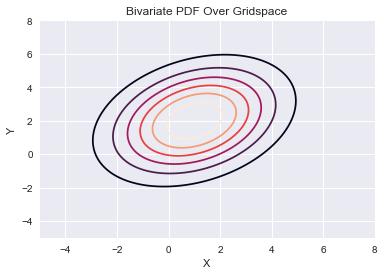

In [191]:
# Construct the PDF of the distribution:
mu = np.array([1,2]);
sigma = np.array([[4,1.2],[1.2,4]])
PDF = scipy.stats.multivariate_normal(mu, sigma)

# Show a contour plot of this distribution:
x,y = np.mgrid[-5:8:.01, -5:8:.01]
pos = np.empty(x.shape + (2,))
pos[:,:,0] = x; pos[:,:,1]=y;
plt.contour(x,y,PDF.pdf(pos))
plt.title('Bivariate PDF Over Gridspace')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [192]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://wikimedia.org/api/rest_v1/media/math/render/svg/5d56be4e902ca19613d81ef148989719b38060c7")

In [193]:
Image(url= "https://wikimedia.org/api/rest_v1/media/math/render/svg/f76ccfa7c2ed7f5b085115086107bbe25d329cec")

In [279]:
# Construct the conditionals on this PDF
# Taken from: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions
std1 = np.sqrt(sigma[0,0])
std2 = np.sqrt(sigma[1,1])
p = sigma[0,1]/(std1*std2)

x_given_y = lambda y: scipy.stats.norm.rvs(loc=mu[0] + std1/std2*p*(y-mu[1]),
                                           scale=(1-p**2)*std1**2)
y_given_x = lambda x: scipy.stats.norm.rvs(loc=mu[1] + std2/std1*p*(x-mu[0]),
                                           scale=(1-p**2)*std2**2)

In [280]:
print((1-p**2)*std1**2)
print((1-p**2)*std2**2)

3.64
3.64


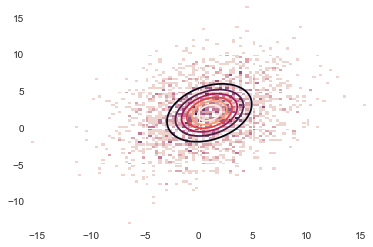

In [292]:
burn = 20000
thin = 5
Nsamp = 10000 + burn

out=gibbs(x_given_y, y_given_x, Nsamp)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.hist2d(out[burn::thin,0],out[burn::thin,1], normed=True, bins=100, cmap=cmap)
plt.contour(x,y,PDF.pdf(pos))
plt.show()

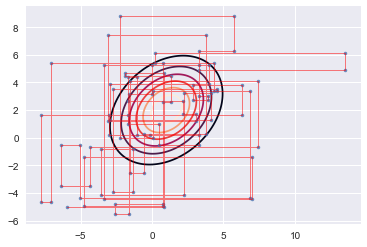

In [282]:
# Movement plots
nr_t = 100
plt.contour(x,y,PDF.pdf(pos))
plt.plot(out[burn:(burn+nr_t), 0],out[burn:(burn+nr_t), 1], '.',alpha=0.8)
plt.plot(out[burn:(burn+nr_t), 0],out[burn:(burn+nr_t), 1], c='r', alpha=0.5, lw=1)
plt.show()

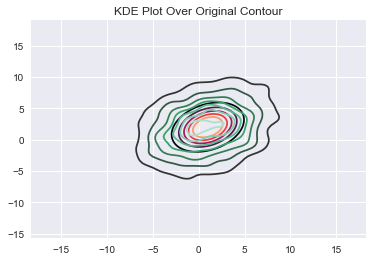

In [293]:
plt.contour(x,y,PDF.pdf(pos))
sns.kdeplot(out[burn::thin,0],out[burn::thin,1])
plt.title('KDE Plot Over Original Contour')
plt.show()

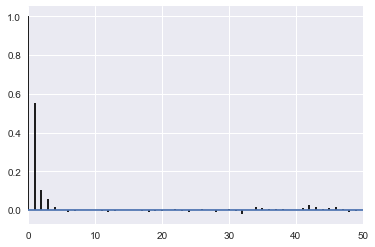

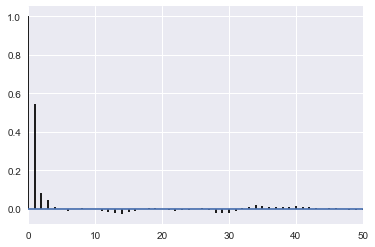

In [284]:
# Correlation plot:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
    plt.show()
corrplot(out[:burn,0], 50)
corrplot(out[:burn,1], 50)

### Burn-in and thinning choices:
We know that, based on the setup of the Gibbs problem, we will need to burn-in and thin the output samples due to high levels of auto-correlation. In this particular example, we have choice a burn-in of ______ and a thin of _____ due t __________

## Problem 2: Rubber Chickens Bawk Bawk!
In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus1.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus2.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith2.png)

(The images above are also included on canvas in case you are offline, see below)

In the following, we will ask you to compare these two products using the various rating statistics. **Larger versions of the images are available in the data set accompanying this notebook**.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


### Part A: Inference

1. Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

In [342]:
# Import the data:
count_loftus = 162
loftus = np.array([.67, .17, .06, .04, .06])
count_toysmith = 410
toysmith = np.array([.60, .11, .07, .08, .14])

In [384]:
# Define the Dirichlet prior
from scipy.special import factorial
from scipy.stats import multinomial

np.random.seed(2)
alpha = [10,1,1,1,2]
theta_prior = np.random.dirichlet(alpha=alpha)
print('Theta Prior:',theta_prior)

# Define multinomial model:
def fx_given_theta(count, Px, Ptheta, alpha=alpha):
    return multinomial.pmf(np.round(Px*count), count, Ptheta)

# Define posterior
def posterior(multiPDF, Px, prior):
    priorPDF = scipy.stats.dirichlet.pdf(Px, prior)
    return multiPDF * priorPDF

# Get outputs of multinomial for each
loftus_out = fx_given_theta(count_loftus, loftus, theta_prior)
toysmith_out = fx_given_theta(count_toysmith, toysmith, theta_prior)

# Posterior for this set
loftus_post = posterior(loftus_out, loftus, theta_prior)
toysmith_post = posterior(toysmith_out, toysmith, theta_prior)
print(loftus_post)
print(toysmith_post)

Theta Prior: [ 0.73027009  0.04951972  0.04725483  0.03474414  0.13821121]
0.0
2.32303757594e-18


## Writing an expression for the posterior PDF

In [385]:
# Sample 1000 values from posterior distribution
pis = scipy.stats(theta_prior,alpha=alpha); print(pis)
sumterm = sum()
alphaP = alpha + sumterm
posterior = dirichlet(alpha = alphaP)

TypeError: 'module' object is not callable

2. Write an expression for the posterior pdf, using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

3. Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
4. Sample 1,000 values of $x$ from the *posterior predictive distribution*.

### Part B: Ranking

1. Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
  

2. Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

3. Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

4. Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)

## Problem 3:  Implementing Rat Tumors in pymc3

(it may help to see the bioassay lab to see how to structure pymc3 code, and also the examples from lecture).

Let us try to do full Bayesian inference with PyMC3 for the rat tumor example that we have solved using explicit Gibbs sampling in lab7. Remember that the goal is to estimate $\theta_i$, the probability of developing a tumor in a population of female rats that have not received treatement. 

The posterior for the 70 experiments may be written thus:

$$p( \{\theta_i\}, \alpha, \beta  \vert  Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

Use uniform priors on $[0,1]$ on the alternative variables $\mu$ (the mean of the beta distribution) and $\nu$:

$$\mu = \frac{\alpha}{\alpha+\beta}, \nu = (\alpha+\beta)^{-1/2}$$

You may then write $\alpha$ and $\beta$ as deterministics which depend on $\mu$ and $\nu$.

Here is the data:

In [116]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

In [117]:
# Load in the data
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
tumory, tumorn 

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  1,  1,  1,  1,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,
         2,  5,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
        10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
        15,  9]),
 array([20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
        20, 19, 19, 18, 18, 27, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49,
        19, 46, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
        48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
        47, 24]))

In [121]:
from pymc3 import Uniform, Normal, Binomial, sample, Model # Import relevant distributions
from pymc3.math import invlogit

with Model() as bioassay_model:

    # Logit-linear model parameters
    mu = Uniform('mu', 0, 1)
    v = Uniform('v', 0, 1)
    
    alpha = mu/v**2
    beta = (1-mu)/v**2

#     # Calculate probabilities of death
#     theta = invlogit(alpha + beta * log_dose_shared)

#     # Data likelihood
#     obs_deaths = Binomial('obs_deaths', n=n_shared, p=theta, observed=deaths)

INFO (theano.gof.compilelock): Refreshing lock /Users/Spencer/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.2-64/lock_dir/lock


KeyboardInterrupt: 

In [118]:
# Full Bayesian treatment:

# number of thetas
numthetas=tumorn.shape[0]

from scipy.special import gammaln

# prior for the hyperparameters
def log_prior(a, b):
    if a <= 0 or b <=0:
        return -np.inf
    return -2.5*np.log(a + b)

# sampling from conditional posterior for the theta
draw_thetas = lambda a,b: beta.rvs(a+tumory,b+tumorn-tumory, size=numthetas)

# conditional posterior (pdf) for alpha
def log_cond_alpha(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(a)) + a*np.sum(np.log(thetas)) + log_prior(a,b)
   
# conditional posterior (pdf) for beta
def log_cond_beta(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(b)) + b*np.sum(np.log(1.0 - thetas)) + log_prior(a,b)
  
# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha(a,b,thetas,proposal_sd, accepts):
    astar = norm.rvs(a,proposal_sd)  # proposed a new alpha
    num = log_cond_alpha(astar,b, thetas) 
    den = log_cond_alpha(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den): 
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return a

def draw_beta(a,b,thetas,proposal_sd, accepts):
    bstar = norm.rvs(b,proposal_sd)
    num = log_cond_beta(a,bstar, thetas)
    den = log_cond_beta(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den):
        accepted=1
    else:
        accepted=0
    accepts['beta'] = accepts['beta'] + accepted
    if accepted:
        return bstar
    else:
        return b

In [ ]:
burnin=20000
numtraces=200000
totaltraces=burnin+numtraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
thetas=np.empty((totaltraces, numthetas))

# these are the step sizes for the proposal distribution
# for our M-H sampling for alpha and beta to be used in Gibbs sampling later
alpha_prop_sd=0.6
beta_prop_sd=3.2

#start positions
alphas[0]=1.
betas[0]=1.
thetas[0,:] = (tumory+0.5)/(tumorn+0.5)

#draw_thetas(alphas[0], betas[0])
accepteds={'alpha':0, 'beta':0}

### Part A:  Report at least the following diagostics on your samples

1. Autocorrelation (correlation dying by lag 20 is fine)
2. Parameter trace correlation after burnin
3. Gewecke
4. Gelman-Rubin
5. $n_{eff}$ (Number of Effective Samples)

### Part B:  Posterior predictive check

Recall from lab notes that in a hierarchical model there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $y_i^*$  given a $\theta_i$, and (2) The distribution of observations $y_j^*$  drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).

1. Carry out posterior predictive checks by using `sample_ppc` to generate posterior-predictives for all 70 experiments. This generates predictives of the first type above. 

2. Plot histograms for these predictives with the actual value shown as a red-dot against the histogram (as in the coal disasters model in lecture 14). Is the data consistent with the predictive?

### Part C:  Shrinkage

1. Plot the posterior median of the death rate parameters $\theta_1, \theta_2, ...\theta_{70}$ against the observed death rates ($y_i/n_i$)

2. Explain the shrinkage by comparing against a 45 degree line as done in the lab.

### PART D:  Experiment 71

Consider an additional experiment -- experiment 71 -- in which 4 out of 14 rats died. 

1. Calculate the marginal posterior of $\theta_{71}$, the "new" experiment,

2. Find the $y_{71}^*$ posterior predictive for that experiment.

**HINT: ** The critical thing to notice is that the posterior including the 71st experiment factorizes:

$$p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)  \propto p(y_{71} \vert n_{71}, \theta_{71} ) p(\theta_{71} \vert \alpha, \beta) p(\theta_{1..70}, \alpha, \beta \vert  D)$$

Then we simply marginalize over everything to get the $\theta_{71}$ posterior:

$$p(\theta_{71} \vert \theta_{1..70}, \alpha, \beta, D) = \int d\alpha \,d\beta \,d\theta_{1..70} \,p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)$$

$$=  \int d\alpha \,d\beta  Beta(\alpha+y_{71}, \beta + n_{71} - y_{71})  \int_{\theta_{1..70}} \,d\theta_{1..70} \,p(\theta_{1..70}, \alpha, \beta \vert  D)$$

The $y_{71}^*$ posterior predictive can be found in the usual way.